# Frequency Domain

In this lab we learn the basics of convolution, sine waves, and fourier transforms.

In [3]:
%matplotlib inline

import numpy as np
from numpy import sin, pi, arange
import matplotlib.pyplot as plt
from ipywidgets import interact_manual, interact

# Modeling a Signal

Let's create a model of a simulated signal using a DataFrame. Each row represensts a sine wave component. The columns encode the frequency, amplitude, and phase of each sine wave component.

In [4]:
import pandas as pd

model = {}
model['components'] = pd.DataFrame({
    'freq': [3, 10, 5 ,15, 35],
    'amplitude': [5, 15, 10, 5, 7],
    'phase': [1/7, 1/8, 1, 1/2, -1/4],
})
model['noise'] = {'magnitude': 2, 'seed': 12321}
model

{'components':    freq  amplitude     phase
 0     3          5  0.142857
 1    10         15  0.125000
 2     5         10  1.000000
 3    15          5  0.500000
 4    35          7 -0.250000, 'noise': {'magnitude': 2, 'seed': 12321}}

We can write a function to generate a signal, taking in the model and sampling frequency as input arguments, like below.

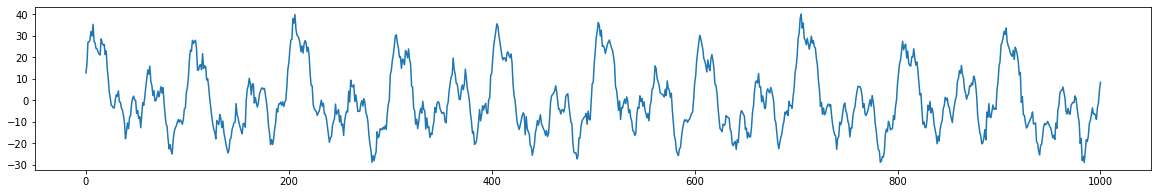

In [5]:
def generate_signal(model, sampling_freq):

    time = arange(-1, 1 + 1/sampling_freq, 1/sampling_freq)

    signals = []    
    for i in model['components'].index:    
        component_i = model['components'].iloc[i]
        amplitude = component_i['amplitude']
        freq = component_i['freq']
        phase = component_i['phase']
        signal_i = amplitude * sin(2*pi*freq*time + phase)
        
        signals.append(signal_i)
    
    signals = np.array(signals)
    
    signal = np.sum(signals, axis=0)
    
    # generate noise
    np.random.seed(model['noise']['seed'])
    noise = model['noise']['magnitude'] * np.random.randn(signals.shape[1])
    
    # add noise to signal
    signal = signal + noise
    
    return signal


def plot_signal(signal):
    plt.figure(figsize=(20,3))
    plt.plot(signal)
    plt.show()

signal = generate_signal(model, 500)
plot_signal(signal)

## Exercise

Using DataFrame to represent the simulated signal gives us the ability to select a subset of components to generate a filtered version of the signal. We can enhance the function `generate_signal` by taking advantage of DataFrame's built-in selection capability. Implement the function `generate_signal_with_selector` below.

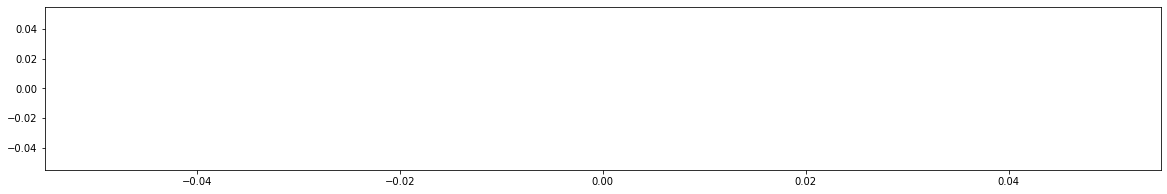

In [6]:
def generate_signal_with_selector(model, sampling_freq, selector_func):
    
    time = arange(-1, 1 + 1/sampling_freq, 1/sampling_freq)

    selected_indices = selector_func(model['components'])
    selected_components = model['components'][selected_indices]

    ## BEGIN SOLUTION
    signals = []
    for i in selected_components.index:        
        component_i = selected_components.loc[i]

        # create a row of signal and append to signals
    

    # combine the signal
    signal = np.sum(signals, axis=0)
    
    # generate noise
    
    # add noise to signal
              
    return signal

    ## END SOLUTION

    
# TEST 1

select_greater_than_10 = lambda df: df['freq'] > 10
signal = generate_signal_with_selector(model, 500, select_greater_than_10)
plot_signal(signal)

# The plot should show the wave form composed of sine waves whose frequencies are greater than 10

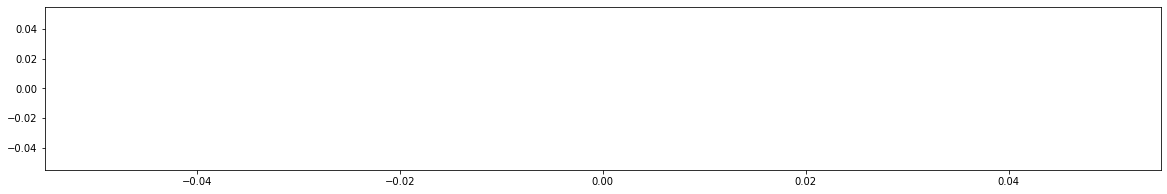

In [7]:
# TEST 2

select_less_than_20 = lambda df: df['freq'] < 20
signal = generate_signal_with_selector(model, 500, select_less_than_20)
plot_signal(signal)

# The plot should show the wave form composed of sine waves whose frequencies are less than 20

# Frequency Domain

In the previous example, we generated a complex signal composed of multiple sine waves oscillating at different frequencies. Typically in data analysis, we only observe the signal and are trying to uncover the generative processes that gave rise to the signal.  In this section, we will introduce the frequency domain and how we can identify if there are any frequencies oscillating at a consistent frequency in our signal using the fourier transform. The fourier transform is essentially convolving different frequencies of sine waves with our data.

One important assumption to note is that the fourier transformations assume that your signals are stationary, which means that the generative processes giving rise to the oscillations do not vary over time. See this [video](http://mikexcohen.com/lecturelets/fftstationarity/fftstationarity.html) for a more in depth discussion on stationarity.  In practice, this assumption is rarely true.  Often it can be useful to use other techniques such as wavelets to look at time x frequency representations. We will not be covering wavelets here, but see this series of [videos](http://mikexcohen.com/lecturelets/convolutiontime/convolutiontime.html) for more information.

# Discrete Time Fourier Transform
We will gain an intution of how the fourier transform works by building our own discrete time fourier transform.  See this accompanying [video](http://mikexcohen.com/lecturelets/fourier/fourier.html) for a more in depth overview.

The discrete Fourier transform of variable $x$ at frequency $f$ is

$X_f = \sum\limits_{k=0}^{n-1} x_k e^{-i2\pi f(k-1)n^{-1}}$
 where $n$ refers to the number of data points in vector $x$, and the capital letter $X_f$ is the fourier coefficient of time series variable $x$ at frequency $f$.
 
Essentially, we create a bank of sine waves at different frequencies that are linearly spaced. We will compute n-1 sine waves as the zero frequency component will be the mean offset over the entire signal and will simply be zero in our example.

Notice that we are computing *complex* sine waves using the `np.exp` function instead of the `np.sin` function. `1j` is how we can specify a complex number in python.  We can extract the real components using `np.real` or the imaginary using `np.imag`. See this [video](http://mikexcohen.com/lecturelets/complexfourier/complexfourier.html) for more information about complex numbers.

Now let's create a bank of n-1 linearly spaced complex sine waves.


In [8]:
import numpy as np
from numpy import exp

sampling_freq = 500
n = sampling_freq * 2 + 1

time = np.arange(0, n, 1) / n

sine_waves = []
for i in range(n):
    sine_waves.append(exp(-1j*2*pi*i*time))
sine_waves = np.array(sine_waves)
sine_waves.shape

(1001, 1001)

Let's look at the first 5 waves to see their frequencies. Remember the first basis function is zero frequency component and reflects the mean offset over the entire signal.

/Users/tom/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


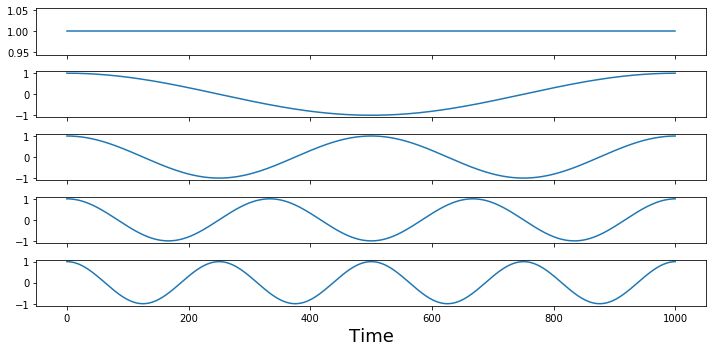

In [9]:
f,a = plt.subplots(nrows=5, figsize=(10,5), sharex=True)
for i in range(0,5):
    a[i].plot(sine_waves[i,:])
plt.xlabel('Time', fontsize=18)
plt.tight_layout()

We can visualize all of the sine waves simultaneously using a heatmap representation.  Each row is a different sine wave, and columns reflect time.  The intensity of the value is like if the sine wave was coming towards and away rather than up and down. Notice how it looks like that the second half of the sine waves appear to be a mirror image of the first half.  This is because the first half contain the *positive* frequencies, while the second half contains the *negative* frequencies.  Negative frequencies capture sine waves that travel in reverse order around the complex plane compared to that travel forward. This becomes more relevant with the hilbert transform, but for the purposes of this tutorial we will be ignoring the negative frequencies.

Text(0.5, 0, 'Time')

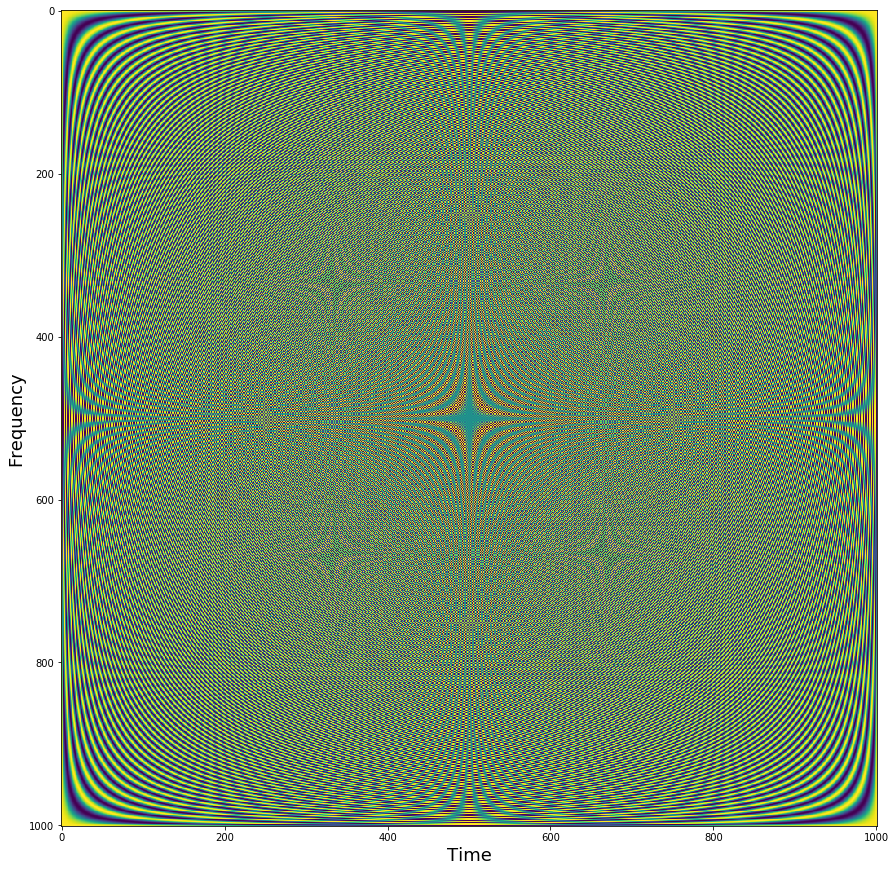

In [10]:
plt.figure(figsize = (15,15))
plt.imshow(np.real(sine_waves))
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Time', fontsize=18)

Now let's take the dot product of each of the sine wave basis set with our signal

In [11]:
signal = generate_signal(model, 500)
fourier = np.dot(signal, sine_waves)
fourier.shape

(1001,)

Now that we have computed the fourier transform, we might want to examine the results.  The fourier transform provides a 3-D representation of the data including frquency, power, and phase. Typically, the phase information is ignored when plotting the results of a fourier analysis. The traditional way to view the information is plot the data as amplitude on the *y-axis* and frequency on the *x-axis*. We will extract amplitude by taking the absolute value of the fourier coefficients. Remember that we are only focusing on the positive frequencies (the 1st half of the sine wave basis functions).

Here the x axis simply reflects the index of the frequency.  The actual frequency is $N/2 + 1$ as we are only able estimate frequencies that are half the sampling frequency, this is called the Nyquist frequency. Watch this [video](http://mikexcohen.com/lecturelets/frequencies/frequencies.html) to hear more about frequencies and zero padding.


Text(0, 0.5, 'Amplitude')

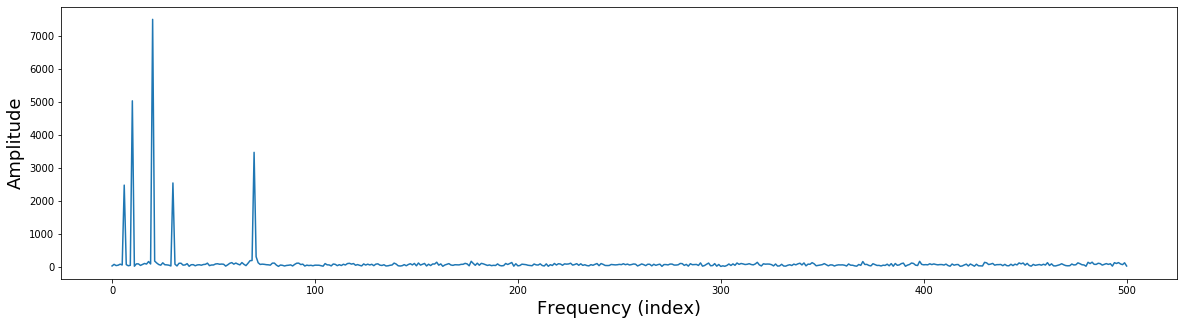

In [12]:
plt.figure(figsize=(20,5))
plt.plot(np.abs(fourier[0:int(np.ceil(len(fourier)/2))]))
plt.xlabel('Frequency (index)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)

Notice that there are 5 different frequencies that have varying amplitudes. Recall that when we simulated this data we added 5 different sine waves with different frequencies and amplitudes. 

`freq = [3, 10, 5 ,15, 35]`
`amplitude = [5, 15, 10, 5, 7]`

Let's zoom in a bit more to see this more clearly and also add the correct frequency labels in $Hz$.

Text(0, 0.5, 'Amplitude')

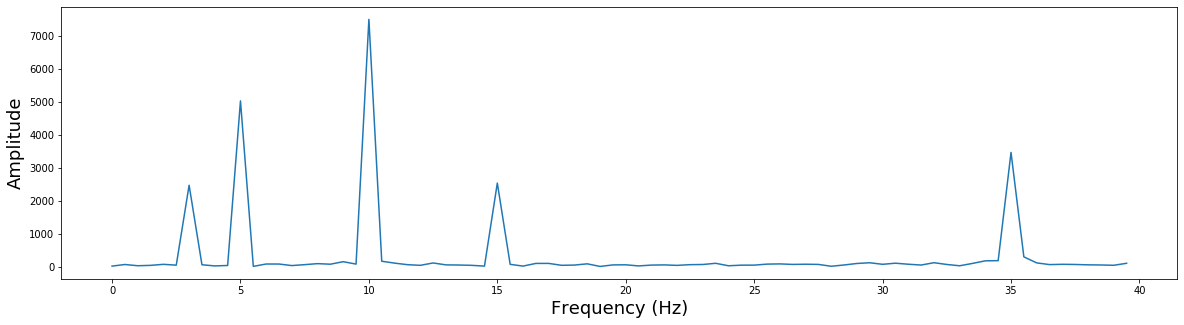

In [13]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(0, 80)/2, np.abs(fourier)[0:80])
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)

## Exercise

The plot above shows five spikes corresponding to the five frequencies used to generate the simulated signal. Now, repeat the code above to compute the fourier (i.e., by taking a doct product) of a "filtered" version of the simulated signal generated using your implementation of `generate_signal_with_selector`. Create a similar plot like above except only a selected subset of the spikes should be seen.

Text(0, 0.5, 'Amplitude')

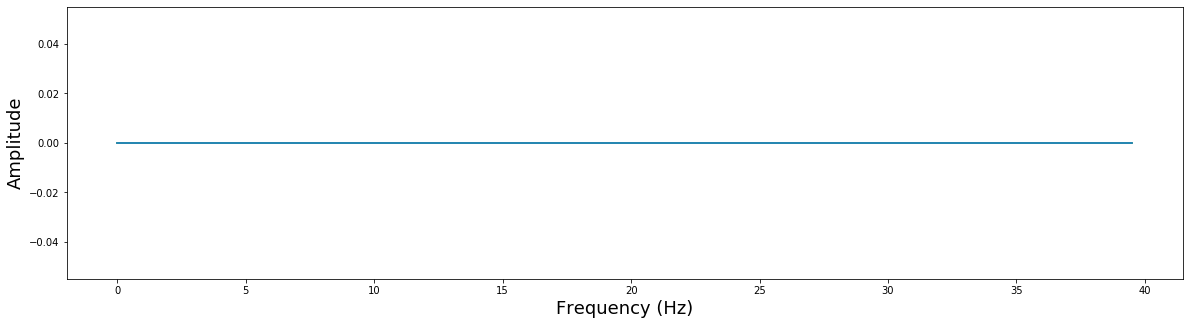

In [14]:
select_less_than_20 = lambda df: df['freq'] < 20
a_filtered_signal = generate_signal_with_selector(model, 500, select_less_than_20)

### BEGIN SOLUTION

signal = a_filtered_signal#generate_signal(model, 500)
fourier = np.dot(signal, sine_waves)
fourier.shape

plt.figure(figsize=(20,5))
plt.plot(np.arange(0, 80)/2, np.abs(fourier)[0:80])
plt.xlabel('Frequency (Hz)', fontsize=18)
plt.ylabel('Amplitude', fontsize=18)
### END SOLUTION

# Expected: A plot that looks like above except there is no spike at Frequency = 35 

# Inverse Fourier Transform

The fourier transform allows you to represent a time series in the frequency domain. We can also invert this transformation and create a time series with only the frequency domain information using the *inverse fourier transform*.

$x_k = \sum\limits_{k=0}^{n-1} X_k e^{i2\pi f(k-1)n^{-1}}$

Notice that we are computing the dot product between the complex sine wave and the fourier coefficients $X$ instead of the time series data $x$.

Text(0.5, 0, 'Time')

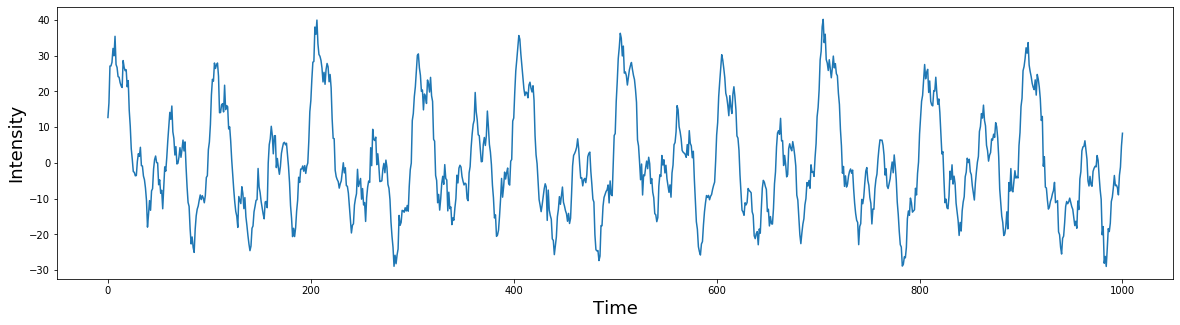

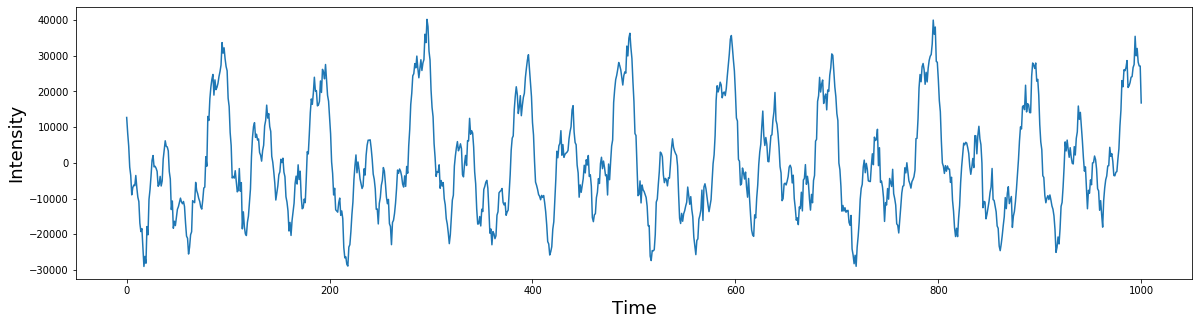

In [23]:
sampling_freq = 500
signal = generate_signal(model, 500)

# plot the simulated signal 
plt.figure(figsize=(20,5))
plt.plot(signal)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)


n = sampling_freq * 2 + 1
time = np.arange(0, n, 1) / n

sine_waves = []
for i in range(n):
    sine_waves.append(exp(-1j*2*pi*i*time))
sine_waves = np.array(sine_waves)

# fourier transform
fourier = np.dot(signal, sine_waves)

# inverse fourier transform
inv_fourier = np.dot(fourier, sine_waves)

plt.figure(figsize=(20,5))
plt.plot(inv_fourier)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

## Exercise

What do you notice when you look at the two wave forms?








# Fast Fourier Transform

The discrete time fourier transform is useful to understand the relationship between the time and frequency domains. However, in practice this method is rarely used as there are more faster and efficient methods to perform this computation. One popular algorithm is called the fast fourier transform (FFT). This function is also in numpy `np.fft.fft`.

Text(0.5, 0, 'Frequency (Hz)')

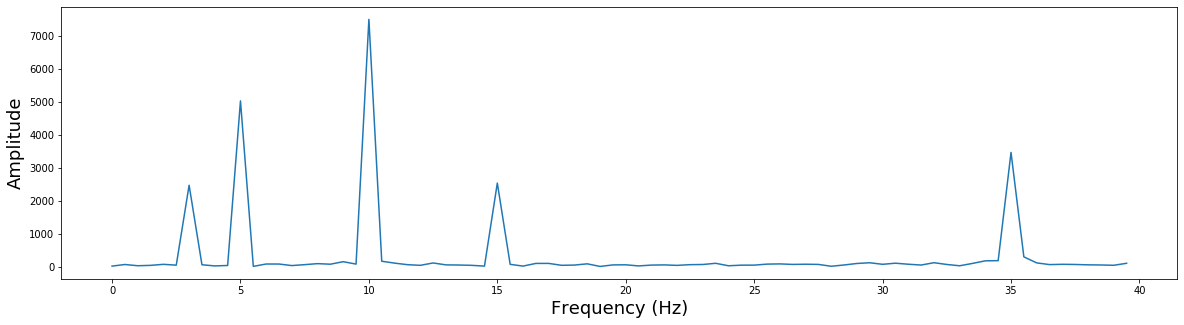

In [28]:
from numpy.fft import fft, ifft

# generate a signal
signal = generate_signal(model, 500)

# compute fast fourier transformation
fourier_fft = fft(signal)

plt.figure(figsize=(20,5))
plt.plot((np.arange(0,80)/2), np.abs(fourier_fft[0:80]))
plt.ylabel('Amplitude', fontsize=18)
plt.xlabel('Frequency (Hz)', fontsize=18)

Let's generate a new signal using the same model by selecting only those whose freq is less or equal to 10. Using fft, the result now shows three spies 

We can also use the `ifft` to perform an inverse fourier transform

/Users/tom/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Time')

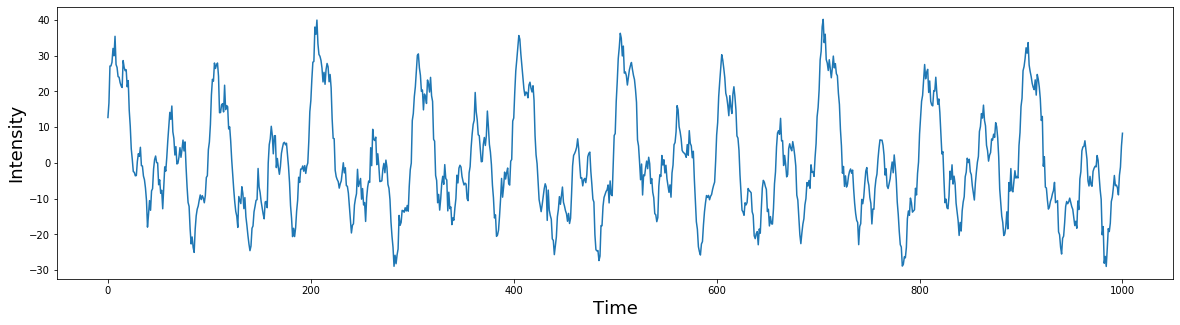

In [29]:
plt.figure(figsize=(20,5))
plt.plot(ifft(fourier))
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

## Exercise

Practice using `fft` and `ifft` on a filtered signal generated using your implementation of `generate_signal_with_selector`.

In [30]:
select_less_than_20 = lambda df: df['freq'] < 20
a_filtered_signal = generate_signal_with_selector(model, 500, select_less_than_20)

# compute and plot the fourier of `a_filtered_signal`

# plot the ifft of the fourier of `a_filtered_signal`


# Convolution Theorem
Convolution in the time domain is the same multiplication in the frequency domain. This means that time domain convolution computations can be performed much more efficiently in the frequency domain via simple multiplication. (The opposite is also true that multiplication in the time domain is the same as convolution in the frequency domain. Watch this [video](http://mikexcohen.com/lecturelets/convolutiontime/convolutiontime.html) for an overview of the convolution theorem and convolution in the frequency domain.


# Filters

Filters can be classified as finite impulse response (FIR) or infinite impulse response (IIR). These terms describe how a filter responds to a single input impulse.  FIR filters have a response that ends at a disrete point in time, while IIR filters have a response that continues indefinitely.

Filters are constructed in the frequency domain and several properties that need to be considers.

- ripple in the pass-band
- attenuation in the stop-band
- steepness of roll-off
- filter order (i.e., length for FIR filters)
- time-domain ringing

In general, there is a frequency by time tradeoff.  The sharper something is in frequency, the broader it is in time, and vice versa.

Here we will use IIR butterworth filters as an example.

# High Pass
High pass filters only allow high frequency signals to remain, effectively *removing* any low frequency information.

Here we will construct a high pass butterworth filter and plot it in frequency space.

**Note**: this example requires using scipy 1.2.1+. To upgrade run `!pip install scipy --upgrae` and then reset your kernel.

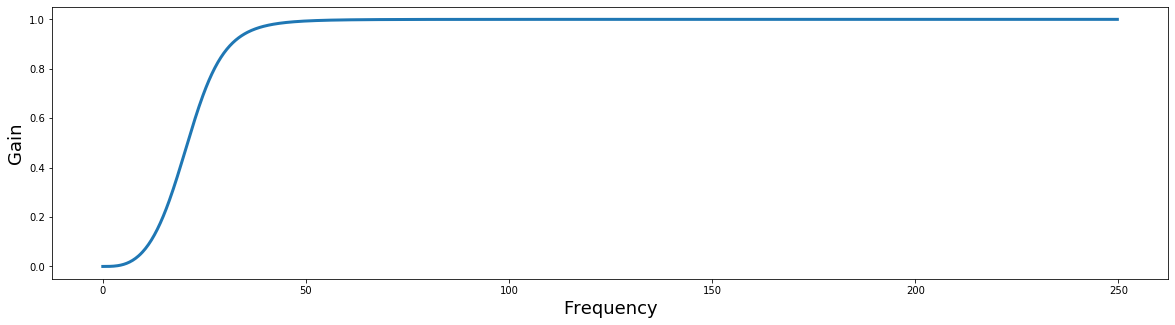

In [45]:
from scipy.signal import butter, filtfilt, freqz

filter_order = 3
frequency_cutoff = 25
sampling_frequency = 500

# Create the filter
b, a = butter(filter_order, frequency_cutoff, btype='high', output='ba', fs=sampling_frequency)

def rad_sample_to_hz(x, fs):
    return (x*fs)/(2*np.pi)

def plot_filter(b, a, fs):
    plt.figure(figsize=(20,5))
    w, h = freqz(b, a, worN=512*2, whole=False)
    plt.plot(rad_sample_to_hz(w, fs), abs(h), linewidth=3)
    plt.ylabel('Gain', fontsize=18)
    plt.xlabel('Frequency', fontsize=18)
    
plot_filter(b, a, sampling_frequency)

Notice how the gain scales from [0,1]?  Filters can be multiplied by the FFT of a signal to apply the filter in the frequency domain. When the resulting signal is transformed back in the time domain using the inverse FFT, the new signal will be filtered. This can be much faster than applying filters in the time domain.

The filter_order parameter adjusts the sharpness of the cutoff in the frequency domain.  Try playing with different values to see how it changes the filter plot.

In [46]:
@interact_manual(frequency_cutoff = 50, sampling_frequency = 500)
def test_butter_filter(frequency_cutoff, sampling_frequency):
    b, a = butter(filter_order, frequency_cutoff, btype='high', output='ba', fs=sampling_frequency)
    plot_filter(b, a, sampling_frequency)

interactive(children=(IntSlider(value=50, description='frequency_cutoff', max=150, min=-50), IntSlider(value=5…

What does the filter look like in the temporal domain?  Let's take the inverse FFT and plot it to see what it looks like as a kernel in the temporal domain.  Notice how changing the filter order adds more ripples in the time domain.

Text(0.5, 0, 'Time')

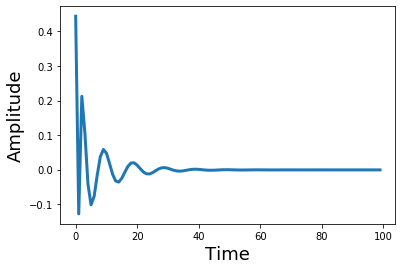

In [47]:
from scipy.signal import sosfreqz

filter_order = 8
sos = butter(filter_order, frequency_cutoff, btype='high', output='sos', fs=sampling_frequency)    
w_sos, h_sos = sosfreqz(sos)

plt.plot(ifft(h_sos)[0:100], linewidth=3)
plt.ylabel('Amplitude', fontsize=18)
plt.xlabel('Time', fontsize=18)

Now let's apply the filter to our data. We will be applying the filter to the signal in the time domain using the `filtfilt` function. This is a good default option, even though there are several other functions to apply the filter. `filtfilt` applies the filter forward and then in reverse ensuring that there is zero-phase distortion.

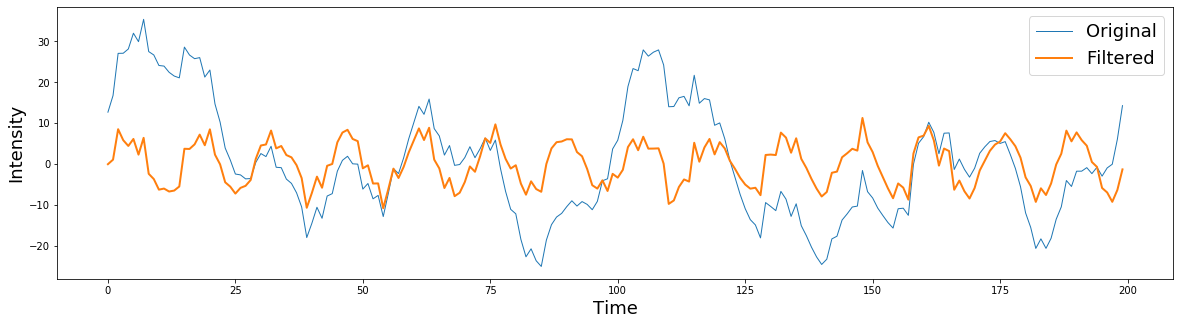

In [48]:
filter_order = 8
frequency_cutoff = 25
sampling_frequency = 500

b, a = butter(filter_order, frequency_cutoff, btype='high', output='ba', fs=sampling_frequency)    

signal = generate_signal(model, 500)

filtered = filtfilt(b, a, signal)

plt.figure(figsize=(20,5))
plt.plot(signal[0:200], linewidth=1)
plt.plot(filtered[0:200], linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

## Exercise

Use your implementation of `generate_signal_with_selected` to simulated a signal filtered by a high pass filter. Create a plot to compare to the signal obtained by using `filtfilt`. See if the two signals look similar.

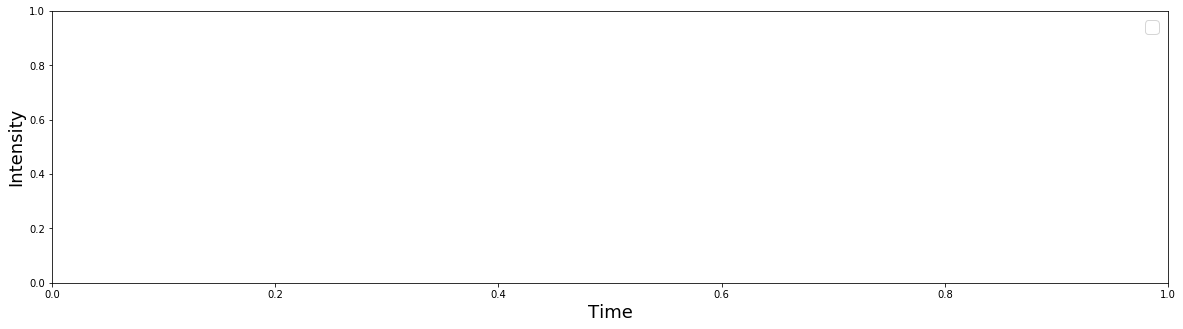

In [49]:
selected = generate_signal_with_selector(model, 500, lambda df: df['freq'] > 25)

plt.figure(figsize=(20,5))
## BEGIN SOLUTION


## END SOLUTION
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Selected','Filtered'], fontsize=18)

# Low Pass
Low pass filters only retain low frequency signals, which *removes* any high frequency information.

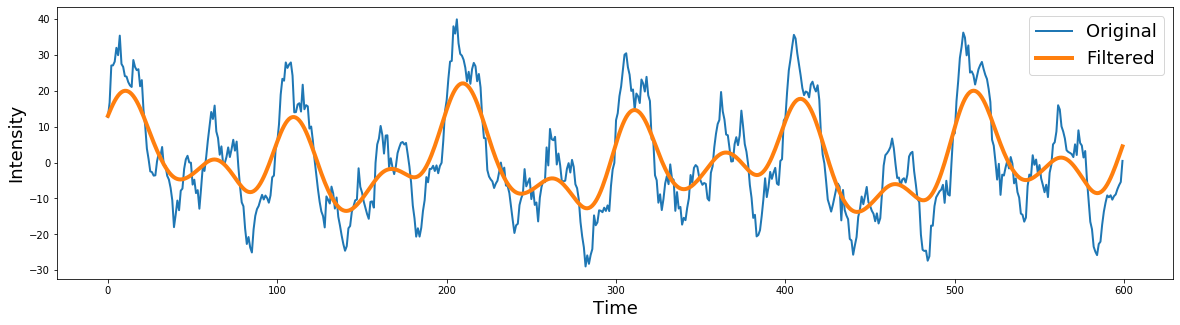

In [50]:
from scipy.signal import butter, filtfilt

filter_order = 2 
frequency_cutoff = 10
sampling_frequency = 500

signal = generate_signal(model, 500)

# Create the filter
b, a = butter(filter_order, frequency_cutoff, btype='low', output='ba', fs=sampling_frequency)

# Apply the filter
filtered = filtfilt(b, a, signal)

plt.figure(figsize=(20,5))
plt.plot(signal[0:600], linewidth=2)
plt.plot(filtered[0:600], linewidth=4)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

What does the filter look like?

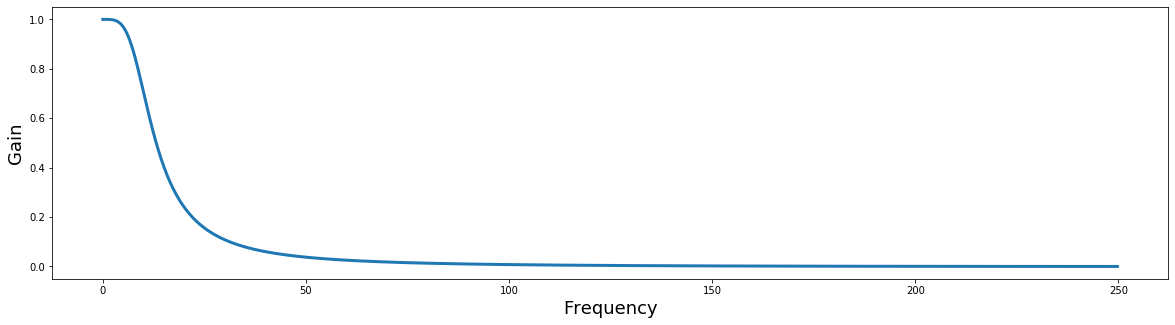

In [51]:
filter_order = 2
frequency_cutoff = 10
sampling_frequency = 500

# Create the filter
b, a = butter(filter_order, frequency_cutoff, btype='low', output='ba', fs=sampling_frequency)

plot_filter(b, a, sampling_frequency)

## Exercise

Use your implementation of `generate_signal_with_selected` to simulated a signal filtered by a low pass filter. Create a plot to compare to the signal obtained by using `filtfilt`. See if the two signals look similar.

In [52]:
selected = generate_signal_with_selector(model, 500, lambda df: df['freq'] <= 10)

# TODO: create a plot to compare two signals

# Bandpass

Bandpass filters permit retaining only a specific frequency. Morlet wavelets are an example of a bandpass filter.  or example a Morlet wavelet is a gaussian with the peak frequency at the center of a bandpass filter.

Let's try selecting removing specific frequencies

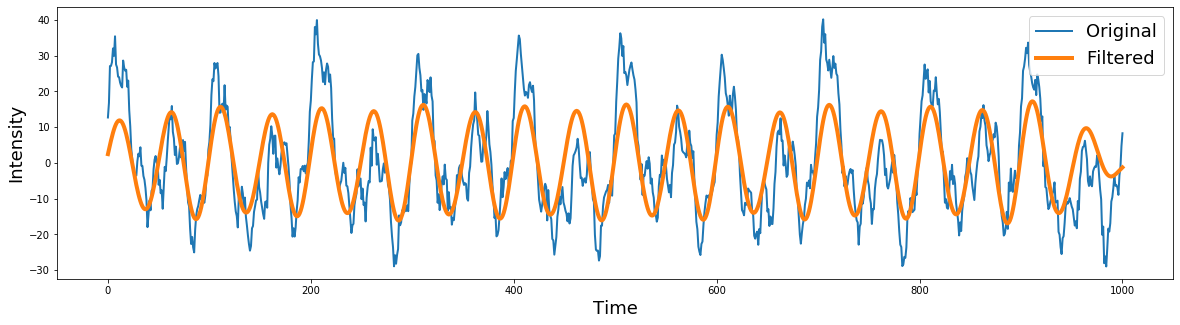

In [53]:
filter_order = 2 
lowcut = 7
highcut = 13

# Create the filter
b, a = butter(filter_order, [lowcut, highcut], btype='bandpass', output='ba', fs=sampling_frequency)

# Apply the filter
filtered = filtfilt(b, a, signal)

plt.figure(figsize=(20,5))
plt.plot(signal, linewidth=2)
plt.plot(filtered, linewidth=4)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

## Exercise

Use your implementation of `generate_signal_with_selected` to simulated a signal filtered by a band pass filter. Create a plot to compare to the signal obtained by using `filtfilt`. See if the two signals look similar.

In [54]:
    # TODO: create a plot to compare 'filtered' to a simulated filtered signal
    # obtained by `generate_signal_with_selected`



# Band-Stop
Bandstop filters remove a specific frequency from the signal

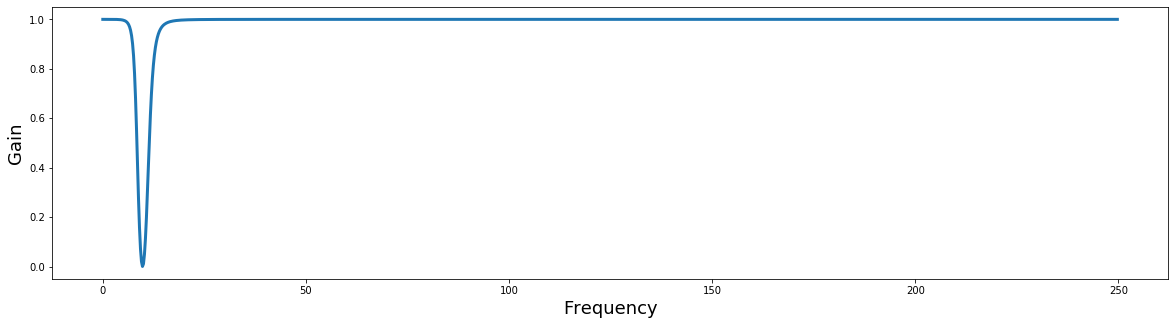

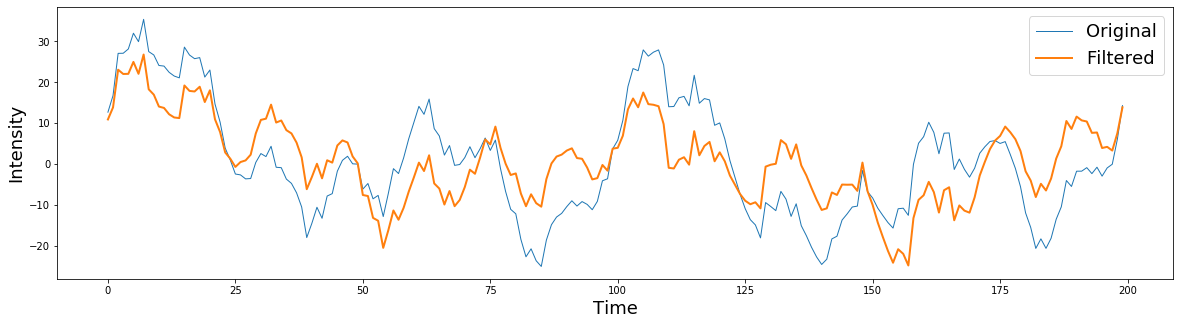

In [44]:
filter_order = 2 
lowcut = 8
highcut = 12

# Create the filter
b,a = butter(filter_order, [lowcut, highcut], btype='bandstop', output='ba', fs=sampling_frequency)

# Plot the filter
plot_filter(b, a, sampling_frequency)

# Apply the filter
filtered = filtfilt(b, a, signal)

plt.figure(figsize=(20,5))
plt.plot(signal[0:200], linewidth=1)
plt.plot(filtered[0:200], linewidth=2)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.legend(['Original','Filtered'], fontsize=18)

## Exercise

Use your implementation of `generate_signal_with_selected` to simulated a signal filtered by a band stop filter. Create a plot to compare to the signal obtained by using `filtfilt`. See if the two signals look similar.

In [55]:
# TODO: create a plot to compare 'filtered' to a simulated filtered signal
# obtained by `generate_signal_with_selected`

# Exercise

Apply what you've learned from this lab to analyze a "bad" signal to uncover the good signal hidden within. Let's suppose we somehow know that the bad signal is the result of a good signal being affected by a drift and a strong high frequenct noises.

Let's load the two signals and plot them.

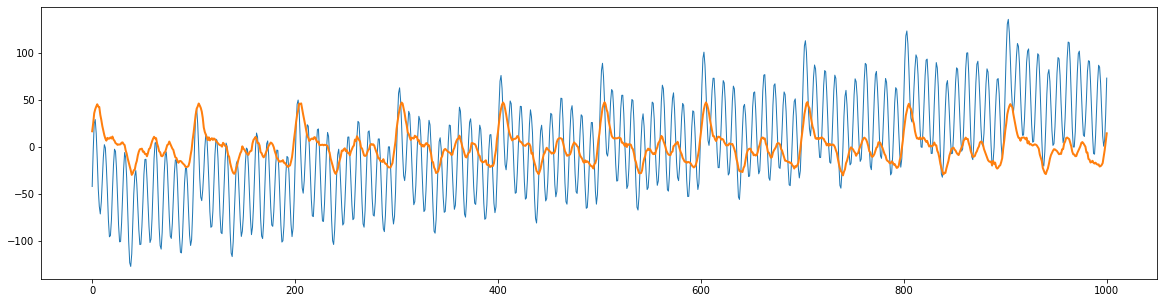

In [95]:
good = np.load('good_signal.npy')
bad = np.load('bad_signal.npy')

plt.figure(figsize=(20,5))
plt.plot(bad, linewidth=1)
plt.plot(good, linewidth=2)

Now, write code to recover the good signal and plot the result. Discuss what the properties of the high frequency noise and drift might be.

In [ ]:
### BEGIN SOLUTION


### END SOLUTION